<a href="https://colab.research.google.com/github/lisya/ML_in_business/blob/lesson07/dz7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('/content/banking_dataset.csv', sep=';')
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Здесь представлен датасет, который содержит информацию о клиентах банках.
Таргет 'y' показывает согласился ли клиент оформить срочный вклад в банке или нет.

**Bank client data:** 

1 - **age** (numeric)

2 - **job** : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services") 

3 - **marital** : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - **education** (categorical: "unknown","secondary","primary","tertiary")

5 - **default**: has credit in default? (binary: "yes","no")

6 - **balance**: average yearly balance, in euros (numeric) 

7 - **housing**: has housing loan? (binary: "yes","no")

8 - **loan**: has personal loan? (binary: "yes","no")

9 - **contact**: contact communication type (categorical: "unknown","telephone","cellular") 

10 - **day**: last contact day of the month (numeric)

11 - **month**: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

12 - **duration**: last contact duration, in seconds (numeric)

13 - **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - **previous**: number of contacts performed before this campaign and for this client (numeric)

16 - **poutcome**: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):

17 - **y** - has the client subscribed a term deposit? (binary: "yes","no")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,45211,NaN,NaN,NaN,40.9362,10.6188,18,33,39,48,95
job,45211,12,blue-collar,9732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,45211,3,married,27214,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,45211,4,secondary,23202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,45211,2,no,44396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,45211,NaN,NaN,NaN,1362.27,3044.77,-8019,72,448,1428,102127
housing,45211,2,yes,25130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,45211,2,no,37967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,45211,3,cellular,29285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,45211,NaN,NaN,NaN,15.8064,8.32248,1,8,16,21,31


**Для всех категориальных фич применим OHE, таргет приведем к виду (0,1)**

In [11]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [14]:
cat_features = list(X.select_dtypes(['object']).columns)

In [15]:
X = pd.get_dummies(X,columns = cat_features , drop_first = True)
X.head(5)

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [18]:
y = np.where(y == 'yes', 1, 0)
y

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
!pip install shap

In [21]:
import xgboost
import shap

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [22]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [26]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

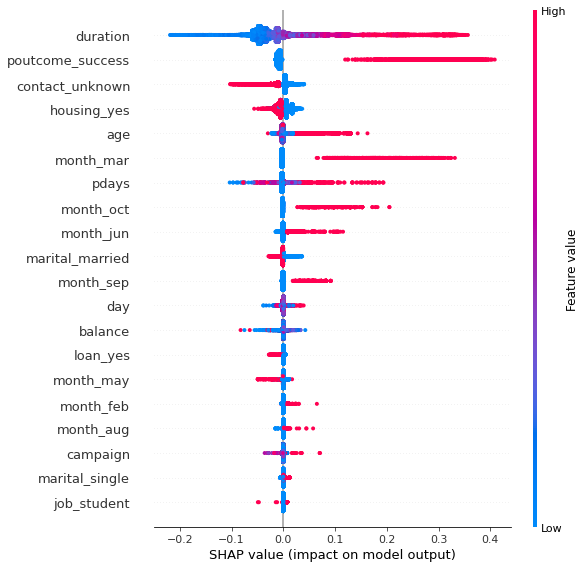

In [24]:
shap.summary_plot(shap_values, X_train)

In [25]:
cat_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

По графику видим что:

Чем выше **duration**, тем выше вероятность что человек откроет счет. Duration - это время последнего ращговора в секундах. Видимо если человек не положил трубку в первые секунды разговора, то шанс что он откроет счет возрастает. 

**poutcome_success**, чем выше признак тем выше шанс открытия счета.Poutcome_success означает удачно проведенную маркетинговую компанию, которой остался доволен клиент. Логично что если клиенту понравилась рекламная акция, то он решил открыть счет.

**contact_unknowh**. Способ связи с клиентом. Тут непонятно как объяснить....

**housing_yes**(есть заем на дом). Получается, что большее количество людей у которых нет заема на дом(наверно ипотека), с большей вероятностью откроую сберегательный счет. Звучит логично.

**age**. Чем старше - тем больше верояность открыть счет.

**pdays**(количество дней, после того как клиенту псоледний раз звонили с предложением открыть счет). Чем выше тем больше шансов открыть счет. Видимо не стоит слишком часто звонить с рекламой.

Ну и также наибольшее количество счетов открывают в **марте**, **октябре** и **июне**


**Построим force plot.**

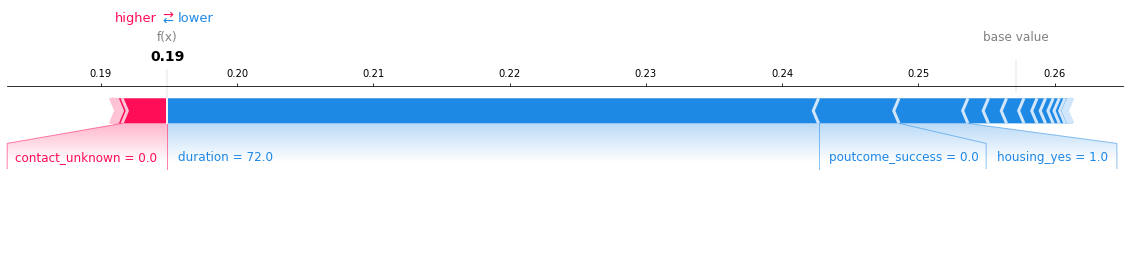

In [72]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], matplotlib=True)

Итак мы построили график который соответвует первой строке нашего X_train.


In [73]:
pd.DataFrame(X_train.iloc[0]).T

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
33362,39,3870,20,72,1,-1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


f(x) = 0.19

Это число предскажет наша модель по данным которые находятся в первой строке. проверим:

In [74]:
model.predict(xgboost.DMatrix(pd.DataFrame(X_train.iloc[0]).T))

array([0.19489357], dtype=float32)

Далее что такое best_value? 

Значению best_value соответсвует explainer.expected_value. 

И насколько я понял это число равно среднему от всех предсказанных значений по нашему датасету. У нас в примере это X_train.

Проверим

In [75]:
explainer.expected_value

0.25714773

In [58]:
y_test = model.predict(xgboost.DMatrix(X_train))
y_test.mean()

0.2571477

Вроде все сходится.
Теперь по фичам.
Красный цвет означает что признак смешает наше предсказание вправо относительно base_value, голубой означает что признак давит влево.

Duration = 72(это же значение видим в первой строке нашего датафрейма), имеет голубой цвет и смешает предсказание влево.

Тоже самое и с poutcome_success и housing_yes.

Contact_unknown сдвигает предсказание вправо.

В итоге как я понял сумма всех этих смешений приводит нас к значению 0.19

Для остальных строк все делается аналогично

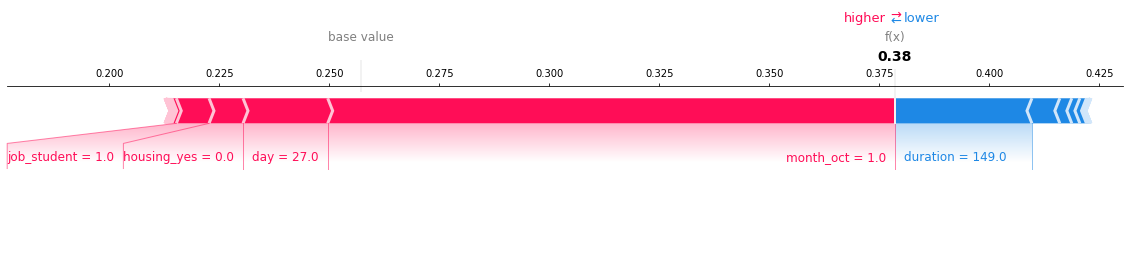

In [76]:
shap.force_plot(explainer.expected_value, shap_values[10,:], X_train.iloc[10,:], matplotlib=True)

In [79]:
pd.DataFrame(X_train.iloc[10]).T

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
42014,36,129,27,149,1,-1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [78]:
f_x = model.predict(xgboost.DMatrix(pd.DataFrame(X_train.iloc[10]).T))
f_x

array([0.37857884], dtype=float32)